<img style="float: left;" src="earth-lab-logo-rgb.png" width="150" height="150" />

# Earth Analytics Education

## Important  - Assignment Guidelines

1. Before you submit your assignment to GitHub, make sure to run the entire notebook with a fresh kernel. To do this first, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart & Run All)
2. Always replace the `raise NotImplementedError()` code with your code that addresses the activity challenge. If you don't replace that code, your notebook will not run.

```
# YOUR CODE HERE
raise NotImplementedError()
```

3. Any open ended questions will have a "YOUR ANSWER HERE" within a markdown cell. Replace that text with your answer also formatted using Markdown.
4. **DO NOT RENAME THIS NOTEBOOK File!** If the file name changes, the autograder will not grade your assignment properly.

* Only include the package imports, code, and outputs that are required to run your homework assignment.
* Be sure that your code can be run on any operating system. This means that:
   1. the data should be downloaded in the notebook to ensure it's reproducible
   2. all paths should be created dynamically using the `os.path.join`
   3. sort lists of dated files even if they are sorted correctly by default on your machine

## Follow to PEP 8 Syntax Guidelines & Documentation

* Run the `autopep8` tool on all cells prior to submitting (HINT: hit shift + the tool to run it on all cells at once!
* Use clear and expressive names for variables. 
* Organize your code to support readability.
* Check for code line length
* Use comments and white space sparingly where it is needed
* Make sure all python imports are at the top of your notebook and follow PEP 8 order conventions
* Spell check your Notebook before submitting it.

For all of the plots below, be sure to do the following:

* Make sure each plot has a clear TITLE and, where appropriate, label the x and y axes. Be sure to include UNITS in your labels.


### Add Your Name Below 
**Your Name:** Robyn Marowitz

<img style="float: left;" src="colored-bar.png"/>

---

# Fire Management Regimes - Yosemite National Park

For this assignment, you will write code to generate a plot of the mean normalized difference vegetation index (NDVI) over time for the Illilouette watershed near Yosemite National Park, USA.

The eventual goal is to characterize different fire regimes by comparing Illilouette watershed over time with control watersheds using the Normalized Burn Ratio index. This assignment will get you started on that larger goal.

## Assignment Goals:
  1. Download the Illilouette watershed boundary
  2. Use a pre-written `EarthExplorerDownloader` *class* to automatically download and decompress one year of Landsat Analysis Ready Multispectral data
  3. Load the downloaded data into a single xarray DataArray, performing necessary pre-processing tasks
  4. Compute and plot the mean NDVI in the watershed over time

## About the Earth Explorer M2M Interface
The data that you will use for this week is available Earth Explorer. However, you will need more data that you can reasonably download using the web interface for Earth Explorer. Instead, you will need to write some code to download data using the Earth Explorer [Machine to Machine (M2M) interface](https://m2m.cr.usgs.gov/).

**You will need to [sign up for access the the M2M interface](https://ers.cr.usgs.gov/profile/access) to complete this assignment -- please note that it can take a day or two to get access**

Not sure what is supposed to be here, but I have an active account at this point.

## Background: Fire Management in California, USA

[Review this paper comparing runoff ratio in two California watersheds](https://link.springer.com/article/10.1007/s10021-016-0048-1). (You should have access from the CU libraries using your IdentiKey)

In the cell below, write a summary of the article, including a site description. What are the implications of this study for wildfire management practices?

### Site Description ###
#### Fire Management in California (Illilouette Creek Basin)####
* This article discusses managed wildfires in the Illilouette Creek Basin in Yosemite National Park in California.
* Illilouette is one of only two locations in the Sierra Nevadas that does managed wildfires. It can be hard to do controlled burns due to risks of people and property damage.
* The area of the Illouette Creek Basin (ICB) is 150 km squared. 
* ICB experiences a lot of drought in its forestry, so the study is looking a lot at soil moisture. 
* The study compares a few different watersheds without fire management versus ICD with fire management. 

## Define your study area

You are interested in checking the NDVI over time at the Illilouette watershed.

### Download watershed boundary

1. Start by downloading and caching the watershed boundary dataset for 2-digit HUC 18 (roughly California). Watershed Boundary Dataset (WBD) download urls can be found at [USGS's National Map Staged Products site](https://prd-tnm.s3.amazonaws.com/index.html?prefix=StagedProducts/Hydrography/WBD/HU2/Shape/) **Open your zip file path with 'wb' (binary write) permissions in order to dump the response content there.**

2. The zip file will contain shapefiles of watersheds of different [Hydrologic Unit Code (HUC) lengths](https://nas.er.usgs.gov/hucs.aspx). You will need to unzip the downloaded file using the standard library `zipfile`. To access the WBD data. The `Shape` > `WBDHU12.shp` file contains the basins for this study.
  * Check out this [example of how to access `.zip` file contents](https://docs.python.org/3/library/zipfile.html#zipfile.ZipFile.open). Once you have a zipfile object, use the `.extractall()` method to unzip.
  * A second example may be found in the EarthExplorerDownloader class defined below

3. Select your watershed of interest from the `GeoDataFrame`. Note that the WBD does **not** contain gage numbers as are referenced in the paper, so you will have to find the watershed by name. You can **search for strings in a GeoDataFrame column using the `.str.contains()` method** of GeoSeries.

**Return the filtered GeoDataFrame with one row per watershed**

In [1]:
from cryptography.fernet import Fernet
import os
from glob import glob as glob
import pathlib
import tarfile
import regex as re

import json
import numpy as np
import folium
import geopandas as gpd
import pandas as pd
import requests
import zipfile
import rioxarray as rxr
import xarray as xr

In [2]:
working_dir = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'fire-management')
if not os.path.exists(working_dir):
    os.makedirs(working_dir)
    
os.chdir(working_dir)

In [3]:
# Download watershed boundary
override_cache = True
wbd_18_url = (
    "https://prd-tnm.s3.amazonaws.com/StagedProducts/"
    "Hydrography/WBD/HU2/Shape/WBD_18_HU2_Shape.zip"
)
wbd_18_dir = 'water-boundary-dataset-hu18'
wbd_18_path = os.path.join(wbd_18_dir, wbd_18_dir + '.zip')
# cache WBD file
if not os.path.exists(wbd_18_dir):
    os.makedirs(wbd_18_dir)
    
if (not os.path.exists(wbd_18_dir)) or override_cache:
    response = requests.get(wbd_18_url)
    
    with open(wbd_18_path, 'wb') as wbd_18_file:
        wbd_18_file.write(response.content)
        
    with zipfile.ZipFile(wbd_18_path, 'r') as wbd_zipfile:
        wbd_zipfile.extractall(wbd_18_dir)

In [4]:
wbd_hu12_uri = 'zip://{zip_path}!{subpath}'.format(
    zip_path=wbd_18_path, 
    subpath=os.path.join('Shape', 'WBDHU12.shp'))

wbd_hu12_gdf = gpd.read_file(wbd_hu12_uri)

In [5]:
watersheds = ['Illilouette', 'Strawberry Creek']

watershed_gdfs = []
for watershed_name in watersheds:
    watershed_gdf = wbd_hu12_gdf[
        wbd_hu12_gdf.name.str.contains(watershed_name)]
    watershed_gdfs.append(watershed_gdf)
    
wbd_gdf = pd.concat(watershed_gdfs)
wbd_gdf.total_bounds

array([-119.59436018,   33.67830762, -116.67180579,   37.72574759])

### Generate a site map

Your `folium` map should contains your watershed boundaries along with a terrain basemap. Bonus - label each watershed boundary layer and tooltip with its name. 

Check out some [example code from the folium documentation](https://python-visualization.github.io/folium/quickstart.html#GeoJSON/TopoJSON-Overlays).

In [6]:
wbd_18_path = os.path.join(wbd_18_dir, 'Shape', 'WBDHU12.shp')
wbd_18_gdf = gpd.read_file(wbd_18_path)
ill_gdf = wbd_18_gdf[wbd_18_gdf.name.str.contains('Illilouette')]
ill_gdf

,tnmid,metasource,sourcedata,sourceorig,sourcefeat,loaddate,referenceg,areaacres,areasqkm,states,...,name,hutype,humod,tohuc,noncontrib,noncontr_1,shape_Leng,shape_Area,ObjectID,geometry
3434,{B3D4CF2D-462A-4AE0-9CC6-944443B36046},{1FD08DBF-22B4-4D08-89F6-2F8BC46737A9},None,None,None,2016-04-08,None,38936.82,157.57,CA,...,Illilouette Creek,M,NM,180400080108,0.0,0.0,0.607496,0.01609,3435,"POLYGON ((-119.43823 37.70989, -119.43807 37.7..."


In [7]:
m = folium.Map(
    location=(ill_gdf.centroid.y, ill_gdf.centroid.x),
    tiles='cartodbpositron',
    zoom_start=11,
)
folium.GeoJson(ill_gdf, name='Illilouette Basin').add_to(m)
m

/var/folders/8m/cwkysk5d759d5nwvy056cdxw0000gn/T/ipykernel_28309/1623411042.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location=(ill_gdf.centroid.y, ill_gdf.centroid.x),
/var/folders/8m/cwkysk5d759d5nwvy056cdxw0000gn/T/ipykernel_28309/1623411042.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location=(ill_gdf.centroid.y, ill_gdf.centroid.x),


## Download Multispectral Data Using the Machine to Machine (M2M) Earth Explorer API

**You will need to have your Earth Explorer account activated to work with M2M to complete this section**

To start, download 6 months of multispectral surface reflectance data using the following parameters:
  - Use the "Landsat 4-9 C2 U.S. ARD" dataset
  - Use the watershed boundary as the spatial boundary
  - 6 months of data (you will find that you need to make changes to the code to download more than 100 scenes)

The cell below contains two classes that can help you with the download. Your task here is to:
  * **Add descriptive docstrings to each class and method in the cell below**. What does each method do?
  * In the cell below, initialize the class and use it to complete the Earth Explorer download. You should only need a few lines of code to complete the download (note that it can take in the vicinity of 20 minutes for Earth Explorer to prepare your download, and the class below should update you on the status of your download every 30 seconds.)
  
The steps for downloading using the classes below are:
  1. Define the bounding box
  2. Initialize the EarthExplorerDownloader instance
    * one year of data (Start with less to test your code!)
    * only download data needed to cover the watershed boundary
    * Dataset: "Landsat 4-9 C2 U.S. ARD"
  3. Submit a download request
  4. Download

In [8]:
class BBox:
    """
    Create a bouding box for the area of the data we are downloading.
    """
    def __init__(self, llx, lly, urx, ury):
        self.llx, self.lly, self.urx, self.ury = llx, lly, urx, ury

    @property
    def spatial_filter(self):
        """Build dictionary of the bounds."""
        return {
            'filterType': "mbr",
            'lowerLeft': {'latitude': self.lly, 'longitude': self.llx},
            'upperRight': {'latitude': self.ury, 'longitude': self.urx}}

class EarthExplorerDownloader:
    """Request and download Landsat data from Earth Explorer."""

    base_url = "https://m2m.cr.usgs.gov/api/api/json/stable/{endpoint}"
    product_filter = {'productName': 'C2 ARD Tile Surface Reflectance Bundle Download'}
    dld_file_tmpl = '{display_id}.tar'

    def __init__(self, dataset, label, bbox, start, end):
        self.api_key = None
        self.login()
        
        self.dataset, self.label = dataset, label
        self.bbox, self.start, self.end = bbox, start, end
        
        self.temporal_filter = {'start': start, 'end': end}
        self.acquisition_filter = self.temporal_filter
        
        self.path_tmpl = os.path.join(self.label, self.dld_file_tmpl)
        if not os.path.exists(label):
            os.makedirs(label)
        
        self._dataset_alias = None

    def get_ee_login_info(self, info_type):
        """Get login information for M2M Api.
        
        Using fernet the notebook will ask the user to input their 
        login information. The information will be stored in ".ee_" 
        files.
        
        """
        
        # Generate and store key
        key_path = os.path.join(pathlib.Path.home(), '.ee_key')
        if not os.path.exists(key_path):
            print('Generating new key...')
            key = Fernet.generate_key()
            with open(key_path, 'wb') as key_file:
                key_file.write(key)
        with open(key_path, 'rb') as key_file:
            key = key_file.read()
        fernet = Fernet(key)

        # Collect and store login info
        info_path = os.path.join(
            pathlib.Path.home(),
            '.ee_{}'.format(info_type))
        if not os.path.exists(info_path):
            info = input('Enter {}: '.format(info_type))
            with open(info_path, 'wb') as info_file:
                info_file.write(fernet.encrypt(bytes(info, 'utf-8')))
        with open(info_path, 'rb') as info_file:
            return fernet.decrypt(info_file.read()).decode("utf-8")

    def login(self):
        """Get login info from the `ee` files and login via API."""
        if self.api_key is None:
            login_payload = {
                'username': self.get_ee_login_info('username'), 
                'password': self.get_ee_login_info('password')}
            self.api_key = self.post("login", login_payload)
            print('Login Successful')
        
    @property
    def headers(self):
        """Gerenerate header for API."""
        if self.api_key is None:
            return None
        return  {'X-Auth-Token': self.api_key}
    
    def logout(self):
        """Logout."""
        self.post("logout", None)
        print("Logged Out\n\n")

    def post(self, endpoint, data):
        # Send POST requests
        url = self.base_url.format(endpoint=endpoint)
        response = requests.post(url, json.dumps(data), headers=self.headers)
        
        # Raise any HTTP Errors
        response.raise_for_status()
        
        # Return data
        return response.json()['data']
    
    @property
    def dataset_alias(self):
        """Use dataset input to get dataset_alias."""
        if self._dataset_alias is None:
            print("Searching datasets...")
            params = {
                'datasetName': self.dataset,
                'spatialFilter': self.bbox.spatial_filter,
                'temporalFilter': self.temporal_filter}
            datasets = self.post("dataset-search", params)
            
            # Get a single dataset alias
            if len(datasets) > 1:
                print(datasets)
                raise ValueError('Multiple datasets found - refine search.')
            self._dataset_alias = datasets[0]['datasetAlias']
            
            print('Using dataset alias: {}'.format(self._dataset_alias))
        return self._dataset_alias
    
    def find_scene_ids(self):
        params = {
            'datasetName': self.dataset_alias,
            'startingNumber': 1,
            
            'sceneFilter': {
                'spatialFilter': self.bbox.spatial_filter,
                'acquisitionFilter': self.acquisition_filter}}
        
        print("Searching scenes...")
        scenes = self.post("scene-search", params)
        print('Found {} scenes'.format(scenes['recordsReturned']))
        return scenes
    
    def find_available_product_info(self):
        scenes = self.find_scene_ids()
        params = {
            'datasetName': self.dataset_alias, 
            'entityIds': [scene['entityId'] for scene in scenes['results']]}
        products = self.post("download-options", params)

        # Aggregate a list of available products
        product_info = []
        for product in products:
            # Make sure the product is available for this scene
            if product['available']==True or product['proxied']==True:
                product_info.append({
                    'entityId': product['entityId'],
                    'productId': product['id']})
        if not product_info:
            raise ValueError('No available products.')
        return product_info

    def submit_download_request(self):
        product_info = self.find_available_product_info()
        # Did we find products?
        if product_info:
            # Request downloads
            params = {
                'downloads': product_info,
                'label': self.label}
            downloads = self.post("download-request", params)
            print('Downloads staging...')
        else:
            raise ValueError(
                'No products found with the specified boundaries.')
    
    def check_download_status(self):
        params = {'label': self.label}
        downloads = self.post("download-retrieve", params)
        return downloads
    
    def wait_for_available_downloads(self, timeout=None):
        keep_waiting = True
        while keep_waiting:
            downloads = self.check_download_status()
            n_queued = downloads['queueSize']
            keep_waiting = n_queued > 0
            if keep_waiting:
                print("\n", n_queued,
                      "downloads queued but not yet available. "
                      "Waiting for 30 seconds.\n")
                time.sleep(30)
            
            if not timeout is None:
                timeout -= 30
                if timeout < 0:
                    break

        return downloads
        
    def download(self, wait=True, timeout=None, override=True):
        # Check download status
        if wait:
            downloads = self.wait_for_available_downloads(timeout=timeout)
        else:
            downloads = self.check_download_status()
            
        available_or_proxied = (
            downloads['available'] 
            + [dld for dld in downloads['requested'] if dld['statusCode']=='P'])
        if not available_or_proxied:
            raise ValueError('No available downloads.')
        
        # Download available downloads
        for download in available_or_proxied:
            # Filter out products
            if not self.product_filter is None:
                match = [download[k]==v for k, v in self.product_filter.items()]
                if not all(match):
                    continue
            
            # Download and save compressed file
            dld_path = self.path_tmpl.format(display_id=download['displayId'])
            # Cache downloads
            if override or not os.path.exists(dld_path):
                print('Saving download: {}'.format(download['displayId']))
                with open(dld_path, 'wb') as dld_file:
                    response = requests.get(download['url'])
                    dld_file.write(response.content)
            
            self.uncompress(dld_path)
                    
    def uncompress(self, download_path):
        # Extract compressed files
        with tarfile.TarFile(download_path, 'r') as dld_tarfile:
            dld_tarfile.extractall(self.label)

## Note
I did not include docstrings on some of the functions because it felt like both the name and the actions in the function were self explained. 

In [9]:
ill_bbox = BBox(*ill_gdf.total_bounds)

In [10]:
# Download data from Jan 2020 to June 2020
landsat_downloader = EarthExplorerDownloader(
    dataset="Landsat 4-9 C2 U.S. ARD",
    label="landsat-ard-ill-2020",
    bbox= ill_bbox,
    start='2020-01-01', end='2020-06-01',
)
landsat_downloader

Login Successful


In [11]:
# Submit the request and download 
# landsat_downloader.submit_download_request()
# landsat_downloader.download()

# A Time Series of Mean NDVI For the Illilouette Watershed

Now that you have downloaded some multispectral data, you can compute NDVI over time. Over a long period of time, these computations can help to characterize the fire management regimes in different watersheds.

## Get information about the files you downloaded
Using the `glob` library, create a `DataFrame` containing the following information about each scene you downloaded:
  - Band raster file path
  - Corresponding cloud/aerosol QA path (file ending in 'QA_AEROSOL.TIF')
  - Date
  - Band

Hints:
 * If you have a list of dictionaries with matching keys, you can make a DataFrame using `pd.DataFrame(data=list_of_dictionaries)`.
 * Need to look at some example file names? Use the code `ls | head -n 25` in `bash` to view the first 25 of the files you downloaded.

YOUR ANSWER HERE

In [12]:
landsat_dir = landsat_downloader.label
tif_paths = sorted(glob(os.path.join(landsat_dir, 'LC08*SR_B*.TIF')))

def get_band_info(tif_path):
    """Extracts band and date info from a Landsat file path.
    
    Parameters
    ----------
    tif_path : str
    
    """
    tif_re = re.compile(r'(?P<base>LC08_CU_003009_(?P<date>\d+)_\d+_02_SR_)B(?P<band>\d).TIF')
    tif_match = tif_re.search(tif_path)
    
    return {
        'band_path': tif_path,
        'date': pd.to_datetime(tif_match.group('date')),
        'band': int(tif_match.group('band')),
        'qa_path': tif_match.group('base') + 'QA_AEROSOL.TIF'
    }
    

band_df = pd.DataFrame([get_band_info(path) for path in tif_paths])
band_df

,band_path,date,band,qa_path
0,landsat-ard-ill-2020/LC08_CU_003009_20200210_2...,2020-02-10,1,LC08_CU_003009_20200210_20210504_02_SR_QA_AERO...
1,landsat-ard-ill-2020/LC08_CU_003009_20200210_2...,2020-02-10,2,LC08_CU_003009_20200210_20210504_02_SR_QA_AERO...
2,landsat-ard-ill-2020/LC08_CU_003009_20200210_2...,2020-02-10,3,LC08_CU_003009_20200210_20210504_02_SR_QA_AERO...
3,landsat-ard-ill-2020/LC08_CU_003009_20200210_2...,2020-02-10,4,LC08_CU_003009_20200210_20210504_02_SR_QA_AERO...
4,landsat-ard-ill-2020/LC08_CU_003009_20200210_2...,2020-02-10,5,LC08_CU_003009_20200210_20210504_02_SR_QA_AERO...
5,landsat-ard-ill-2020/LC08_CU_003009_20200210_2...,2020-02-10,6,LC08_CU_003009_20200210_20210504_02_SR_QA_AERO...
6,landsat-ard-ill-2020/LC08_CU_003009_20200210_2...,2020-02-10,7,LC08_CU_003009_20200210_20210504_02_SR_QA_AERO...
7,landsat-ard-ill-2020/LC08_CU_003009_20200226_2...,2020-02-26,1,LC08_CU_003009_20200226_20210504_02_SR_QA_AERO...
8,landsat-ard-ill-2020/LC08_CU_003009_20200226_2...,2020-02-26,2,LC08_CU_003009_20200226_20210504_02_SR_QA_AERO...
9,landsat-ard-ill-2020/LC08_CU_003009_20200226_2...,2020-02-26,3,LC08_CU_003009_20200226_20210504_02_SR_QA_AERO...


## Clip and mask Landsat data

Write a function, multiple functions or a class to reproducibly perform the following steps:
  * open a raster in your DataFrame
  * clip it to the watershed boundary
  * mask data outside the valid range of 0-40000
  * mask data covered by clouds
    * open the corresponding aerosol QA raster
    * mask locations with values in [328, 392, 840, 904, 1350, 352, 368, 416, 432, 480, 864, 880, 928, 944, 992, 480, 992]
  * filter out data that is more than 50% masked
  
Not every step must be in the function - use your judgement about the most readable and DRY approach. 

In [13]:
ill_ls_gdf = None
nbr_das = []
for date,one_date_df in band_df[band_df.band.isin([5,7])].groupby('date'):
    one_date_bands = {}
    for i, band in one_date_df.iterrows():
        # open data array
        band_da = (
            rxr.open_rasterio(band.band_path, masked=True)
            .squeeze())
        band_da.name = 'reflectance'
    
        # Reproject boundary (1st time only)         
        if ill_ls_gdf is None:
            ill_ls_gdf = ill_gdf.to_crs(band_da.rio.crs)
            bbox = BBox(*ill_ls_gdf.total_bounds)

        # Clip to bounding box
        band_da = band_da.rio.clip_box(
            minx=bbox.llx, miny=bbox.lly,
            maxx=bbox.urx, maxy=bbox.ury)

        band_da = band_da.assign_coords(date=band.date)
        one_date_bands[band.band] = band_da
        
    nbr_da = ((one_date_bands[5] - one_date_bands[7]) 
                  / (one_date_bands[5] + one_date_bands[7]))
        
    nbr_das.append(nbr_da)
    
nbr_das[0]

<xarray.DataArray 'reflectance' (y: 520, x: 531)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 -2.04e+06 -2.04e+06 ... -2.024e+06 -2.024e+06
  * y            (y) float64 1.886e+06 1.886e+06 1.886e+06 ... 1.87e+06 1.87e+06
    spatial_ref  int64 0
    date         datetime64[ns] 2020-02-10

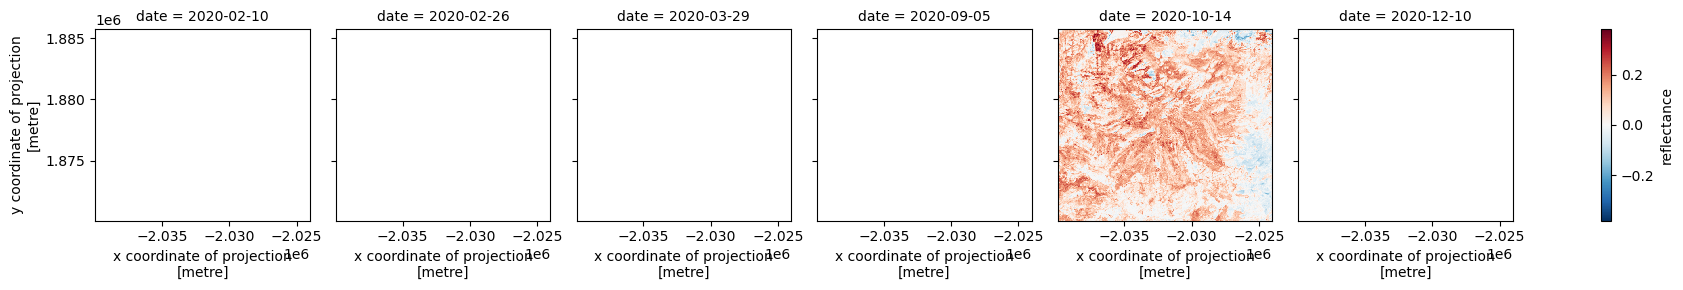

In [14]:
all_nbr_da = xr.concat(nbr_das, dim='date')
all_nbr_da.plot(col='date')

In [15]:
# Here i attempted to mask the cloud covereage but faced errors.

# percent_nonnan = np.isnan(nbr_masked_da).sum() / nbr_masked_da.size

# if (percent_nonnan <= 0.5):
#     # Append each dataarray to a master list.
#     nbr_das.append(nbr_masked_da)

# nbr_stack_da = xr.concat(nbr_das, dim='date')


Test your process by plotting your data using the following code:

```python
landsat_ds.plot(col='date', col_wrap=5, 
                subplot_kws={'xticklabels': 'off',
                             'yticklabels': 'off'})
```

/Users/robynmarowitz/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/xarray/plot/facetgrid.py:169: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig, axes = plt.subplots(


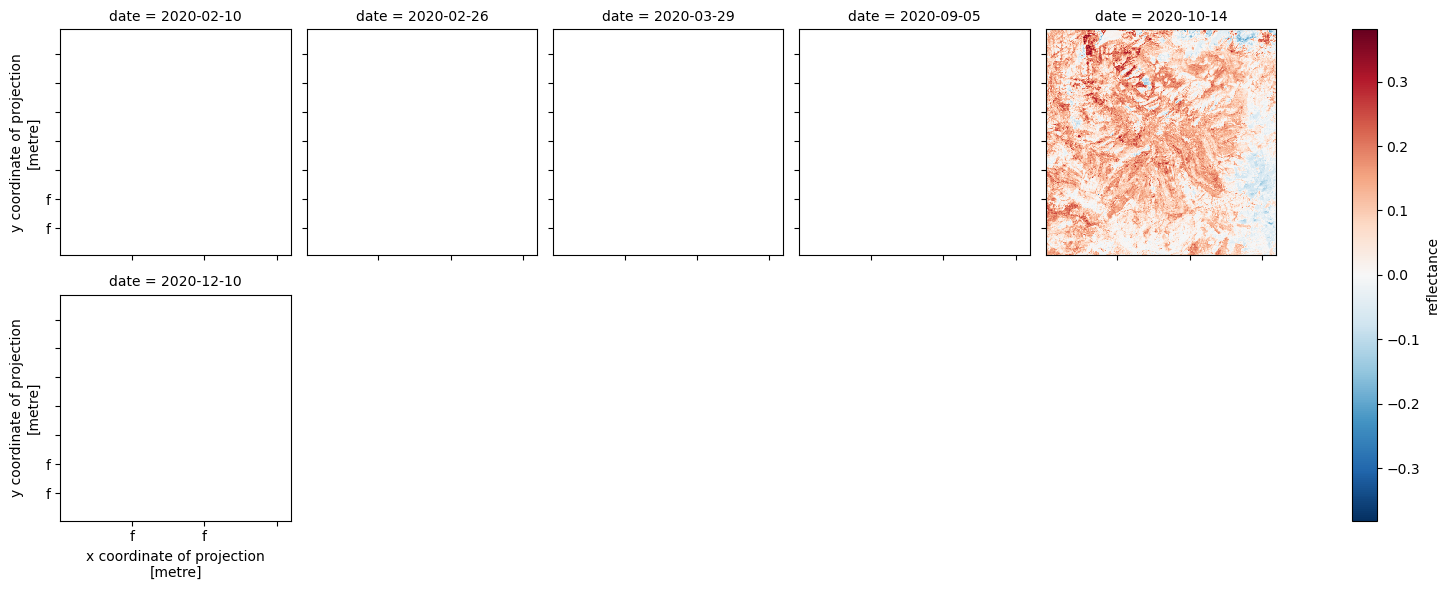

In [16]:
all_nbr_da.plot(col='date', col_wrap=5, 
                subplot_kws={'xticklabels': 'off',
                             'yticklabels': 'off'})

## Plot the mean NBR over time

In the cell below, summarize and plot your DataArray

In [17]:
# nbr_mean = nbr_das[4].groupby('date').mean()
# nbr_mean.plot(label='Mean NBR', color='red'


YOUR ANSWER HERE

# Do not edit this cell! (20 points)

The notebook will also be checked for overall clean code requirements as specified at the **top** of this notebook. Some of these requirements include (review the top cells for more specifics): 

* Notebook begins at cell [1] and runs on any machine in its entirety.
* PEP 8 format is applied throughout (including lengths of comment and code lines).
* No additional code or imports in the notebook that is not needed for the workflow.
* Notebook is fully reproducible. This means:
   * reproducible paths using the os module.
   * data downloaded using code in the notebook.
   * all imports at top of notebook.